In [ ]:
# !pip install torch torchvision
# !pip install imageio

# !pip install matplotlib


%mkdir -p /content
%cd /content

!pip install wandb

!wandb login 21a3a124e1f8e8628af9e98007adf9acb4cb17d1

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=dfad9a499e33627e513035b00ff1257088dcb6a6a71221fb8872aea23484c027
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#@title Helper functions
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid


from six.moves.urllib.request import urlretrieve
import tarfile

import imageio
from urllib.error import URLError
from urllib.error import HTTPError


from torch.distributions import Normal, Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)

    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    return fpath


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def to_var(tensor, cuda=True):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

        Arguments:
            tensor: A Tensor object.
            cuda: A boolean flag indicating whether to use the GPU.

        Returns:
            A Variable object, on the GPU if cuda==True.
    """
    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()


def create_dir(directory):
    """Creates a directory if it doesn't already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)




def merge_images(sources, targets, opts):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    _, _, h, w = sources.shape
    row = int(np.sqrt(opts.batch_size))
    merged = np.zeros([3, row * h, row * w * 2])
    for (idx, s, t) in (zip(range(row ** 2), sources, targets, )):
        i = idx // row
        j = idx % row
        merged[:, i * h:(i + 1) * h, (j * 2) * h:(j * 2 + 1) * h] = s
        merged[:, i * h:(i + 1) * h, (j * 2 + 1) * h:(j * 2 + 2) * h] = t
    return merged.transpose(1, 2, 0)


def generate_gif(directory_path, keyword=None):
    images = []
    for filename in sorted(os.listdir(directory_path)):
        if filename.endswith(".png") and (keyword is None or keyword in filename):
            img_path = os.path.join(directory_path, filename)
            print("adding image {}".format(img_path))
            images.append(imageio.imread(img_path))

    if keyword:
        imageio.mimsave(
            os.path.join(directory_path, 'anim_{}.gif'.format(keyword)), images)
    else:
        imageio.mimsave(os.path.join(directory_path, 'anim.gif'), images)


def create_image_grid(array, ncols=None):
    """
    """
    num_images, channels, cell_h, cell_w = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h * nrows, cell_w * ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w, :] = array[i * ncols + j].transpose(1, 2,
                                                                                                                 0)

    if channels == 1:
        result = result.squeeze()
    return result

import inspect
def printarr(*arrs, float_width=6):
    """
    Print a pretty table giving name, shape, dtype, type, and content information for input tensors or scalars.
    Call like: printarr(my_arr, some_other_arr, maybe_a_scalar). Accepts a variable number of arguments.
    Inputs can be:
        - Numpy tensor arrays
        - Pytorch tensor arrays
        - Jax tensor arrays
        - Python ints / floats
        - None
    It may also work with other array-like types, but they have not been tested.
    Use the `float_width` option specify the precision to which floating point types are printed.
    Author: Nicholas Sharp (nmwsharp.com)
    Canonical source: https://gist.github.com/nmwsharp/54d04af87872a4988809f128e1a1d233
    License: This snippet may be used under an MIT license, and it is also released into the public domain.
             Please retain this docstring as a reference.
    """

    frame = inspect.currentframe().f_back
    default_name = "[temporary]"

    ## helpers to gather data about each array
    def name_from_outer_scope(a):
        if a is None:
            return '[None]'
        name = default_name
        for k, v in frame.f_locals.items():
            if v is a:
                name = k
                break
        return name
    def dtype_str(a):
        if a is None:
            return 'None'
        if isinstance(a, int):
            return 'int'
        if isinstance(a, float):
            return 'float'
        return str(a.dtype)
    def shape_str(a):
        if a is None:
            return 'N/A'
        if isinstance(a, int):
            return 'scalar'
        if isinstance(a, float):
            return 'scalar'
        return str(list(a.shape))
    def type_str(a):
        return str(type(a))[8:-2] # TODO this is is weird... what's the better way?
    def device_str(a):
        if hasattr(a, 'device'):
            device_str = str(a.device)
            if len(device_str) < 10:
                # heuristic: jax returns some goofy long string we don't want, ignore it
                return device_str
        return ""
    def format_float(x):
        return f"{x:{float_width}g}"
    def minmaxmean_str(a):
        if a is None:
            return ('N/A', 'N/A', 'N/A')
        if isinstance(a, int) or isinstance(a, float):
            return (format_float(a), format_float(a), format_float(a))

        # compute min/max/mean. if anything goes wrong, just print 'N/A'
        min_str = "N/A"
        try: min_str = format_float(a.min())
        except: pass
        max_str = "N/A"
        try: max_str = format_float(a.max())
        except: pass
        mean_str = "N/A"
        try: mean_str = format_float(a.mean())
        except: pass

        return (min_str, max_str, mean_str)

    try:

        props = ['name', 'dtype', 'shape', 'type', 'device', 'min', 'max', 'mean']

        # precompute all of the properties for each input
        str_props = []
        for a in arrs:
            minmaxmean = minmaxmean_str(a)
            str_props.append({
                'name' : name_from_outer_scope(a),
                'dtype' : dtype_str(a),
                'shape' : shape_str(a),
                'type' : type_str(a),
                'device' : device_str(a),
                'min' : minmaxmean[0],
                'max' : minmaxmean[1],
                'mean' : minmaxmean[2],
            })

        # for each property, compute its length
        maxlen = {}
        for p in props: maxlen[p] = 0
        for sp in str_props:
            for p in props:
                maxlen[p] = max(maxlen[p], len(sp[p]))

        # if any property got all empty strings, don't bother printing it, remove if from the list
        props = [p for p in props if maxlen[p] > 0]

        # print a header
        header_str = ""
        for p in props:
            prefix =  "" if p == 'name' else " | "
            fmt_key = ">" if p == 'name' else "<"
            header_str += f"{prefix}{p:{fmt_key}{maxlen[p]}}"
        print(header_str, flush=False)
        print("-"*len(header_str), flush=False)

        # now print the acual arrays
        for strp in str_props:
            for p in props:
                prefix =  "" if p == 'name' else " | "
                fmt_key = ">" if p == 'name' else "<"
                print(f"{prefix}{strp[p]:{fmt_key}{maxlen[p]}}", end='', flush=False)
            print("")

    finally:
        del frame


In [ ]:
######################################################################
# Download Translation datasets
######################################################################
data_fpath = get_file(fname='emojis',
                         origin='http://www.cs.toronto.edu/~jba/emojis.tar.gz',
                         untar=True)

data/emojis.tar.gz
Extracting file.


In [ ]:
#@title emoji data loader

def get_emoji_loader(emoji_type, opts):
    """Creates training and test data loaders.
    """
    transform = transforms.Compose([
                    transforms.Resize(opts.image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    transforms.Lambda(lambda x: torch.cat((x, torch.normal(0, 1, size=x.shape)), 2))
                ])

    train_path = os.path.join('data/emojis', emoji_type)
    test_path = os.path.join('data/emojis', 'Test_{}'.format(emoji_type))

    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    train_dloader = DataLoader(dataset=train_dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.num_workers, drop_last=True)
    test_dloader = DataLoader(dataset=test_dataset, batch_size=opts.batch_size, shuffle=False, num_workers=opts.num_workers)

    return train_dloader, test_dloader

In [ ]:

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, num_color, channels=[128, 256, 512, 1024], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(num_color, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], num_color, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    # printarr(embed,h1,h2,h3,h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    return h

In [ ]:


class RectifiedFlow():
  def __init__(self, model=None, num_steps=1000):
    self.model = model
    self.N = num_steps

  def get_train_tuple(self, z0=None, z1=None):
    t = torch.rand((z1.shape[0])).to('cuda')
    # printarr(t,z1,z0)
    tt = t[:, None, None, None]

    z_t =  tt * z1 + (1.-tt) * z0
    target = z1 - z0

    return z_t, t, target

  @torch.no_grad()
  def sample_ode(self, z0=None, N=None):
    ### NOTE: Use Euler method to sample from the learned flow
    if N is None:
      N = self.N
    dt = 1./N
    traj = [] # to store the trajectory
    z = z0.detach().clone()
    batchsize = z0.shape[0]

    traj.append(z.detach().clone())
    for i in range(N):
      t = torch.ones((batchsize)) * i / N
      t = t.to('cuda')
      # printarr(t)

      pred = self.model(z, t)
      z = z.detach().clone() + pred * dt

      traj.append(z.detach().clone())

    return traj

In [ ]:
def train_rectified_flow(rectified_flow, optimizer, lr_scheduler, dloader, inner_iters, args):
  loss_curve = []
  for i in range(inner_iters+1):
    loss_tot = 0
    for batch_idx, (data, dummy) in enumerate(dloader):
      data = data.to("cuda")
      full_width = int(data.shape[3]/2)
      z1 = data[:,:,:,:full_width].detach().clone()
      z0 = data[:,:,:,full_width:].detach().clone()

      z_t, t, target = rectified_flow.get_train_tuple(z0=z0, z1=z1)

      optimizer.zero_grad()
      pred = rectified_flow.model(z_t, t)
      loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
      loss = loss.mean()
      loss.backward()

      optimizer.step()

      loss_tot += np.log(loss.item())

    if lr_scheduler is not None:
      lr_scheduler.step()
    loss_curve.append(loss_tot) ## to store the loss curve
    wandb.log({"loss": loss_curve[-1]})
    if i % 10 == 0:
      print('iteration i =',i, ', loss =', loss_curve[-1])
      z0_test = torch.normal(0, 1, size=(32, args.num_color, args.image_size, args.image_size)).to('cuda')
      traj = rectified_flow_1.sample_ode(z0=z0_test, N=1000)
      images = traj[-1]

      grid = make_grid(images, nrow=8, normalize=True, scale_each=True)
      grid = grid.permute(1, 2, 0).cpu().numpy()
      plt.imshow(grid)
      plt.show()
      torch.save(rectified_flow.model.state_dict(), f"model_{i}.pt")


  return rectified_flow, loss_curve


In [ ]:
#@title args

args = AttrDict()
args_dict = {
              'image_size': 28,
              'learning_rate': 1e-5,
              # 'd_conv_dim':64,
              # 'noise_size':100,
              'num_workers': 0,
              # 'train_iters':20000,
              # 'X':'Apple',  # options: 'Windows' / 'Apple'
              # 'Y': None,
              # 'lr':0.00003,
              # 'beta1':0.5,
              # 'beta2':0.999,
              'batch_size':32,
              # 'checkpoint_dir': 'results/checkpoints_gan_gp1_lr3e-5',
              # 'sample_dir': 'results/samples_gan_gp1_lr3e-5',
              # 'load': None,
              # 'log_step':200,
              # 'sample_every':200,
              # 'checkpoint_every':1000,
              # # 'spectral_norm': False,
              # # 'gradient_penalty': True,
              # # 'least_squares_gan': False,
              # 'd_train_iters': 1
             'num_color':3,
            #  'weight_decay': 5e-4,
}
args.update(args_dict)
import wandb
import os

os.environ['WANDB_NOTEBOOK_NAME'] = 'NEW Copy of Copy of Rectified flow MLP'

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="rectified flow MNIST new",

    # track hyperparameters and run metadata
    config=args
)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find NEW Copy of Copy of Rectified flow MLP.
wandb: Currently logged in as: wens (xmmm). Use `wandb login --relogin` to force relogin


In [ ]:
#@title create data

torch.manual_seed(1)


##########################3
# train_dloader, test_dloader = get_emoji_loader('Apple', args)
# print(len(train_dloader.dataset))

######################
# train_dloader = torch.utils.data.DataLoader(
#   datasets.MNIST('/content/data/', train=True, download=True,
#                              transform= transforms.Compose([
#                               # transforms.Resize(args.image_size),
#                               transforms.ToTensor(),
#                               # transforms.Normalize((0.5), (0.5)),
#                               transforms.Lambda(lambda x: torch.cat((x, torch.normal(0, 1, size=x.shape)), 2))
#                               ])),
#   batch_size=args.batch_size, shuffle=True)
# print(len(train_dloader.dataset))


####################

# train_dloader = torch.utils.data.DataLoader(
#   datasets.FashionMNIST('/content/data/', train=True, download=True,
#                              transform= transforms.Compose([
#                               # transforms.Resize(args.image_size),
#                               transforms.ToTensor(),
#                               # transforms.Normalize((0.5), (0.5)),
#                               transforms.Lambda(lambda x: torch.cat((x, torch.normal(0, 1, size=x.shape)), 2))
#                               ])),
#   batch_size=args.batch_size, shuffle=True)
# print(len(train_dloader.dataset))


########################

d1 = datasets.CIFAR10('/content/data/', train=True, download=True,
                              transform=transforms.Compose([
                              transforms.Resize(args.image_size),
                              transforms.ToTensor(),
                              # transforms.Normalize((0.5), (0.5)),
                              transforms.Lambda(lambda x: torch.cat((x, torch.normal(0, 1, size=x.shape)), 2))
                              ]))
d2 = datasets.CIFAR10('/content/data/', train=False, download=True,
                              transform=transforms.Compose([
                              transforms.Resize(args.image_size),
                              transforms.ToTensor(),
                              # transforms.Normalize((0.5), (0.5)),
                              transforms.Lambda(lambda x: torch.cat((x, torch.normal(0, 1, size=x.shape)), 2))
                              ]))
dd = torch.utils.data.ConcatDataset([d1, d2])

train_dloader = torch.utils.data.DataLoader(dd, batch_size=args.batch_size, shuffle=True)
print(len(train_dloader.dataset))
#######################
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context
# train_dloader = torch.utils.data.DataLoader(
#   datasets.EuroSAT('/content/data/', download=True,
#                               transform=transforms.Compose([
#                               transforms.Resize(args.image_size),
#                               transforms.ToTensor(),
#                               # transforms.Normalize((0.5), (0.5)),
#                               transforms.Lambda(lambda x: torch.cat((x, torch.normal(0, 1, size=x.shape)), 2))
#                               ])),
#   batch_size=args.batch_size, shuffle=True)
# print(len(train_dloader.dataset))

100%|██████████| 170498071/170498071 [00:13<00:00, 12636712.39it/s]


Extracting /content/data/cifar-10-python.tar.gz to /content/data/
Files already downloaded and verified
60000


torch.Size([32, 3, 28, 56]) tensor([8, 3, 1, 4, 9, 4, 8, 5, 4, 9, 5, 5, 5, 6, 7, 0, 5, 6, 5, 6, 1, 6, 0, 0,
        2, 6, 9, 7, 2, 0, 5, 9])


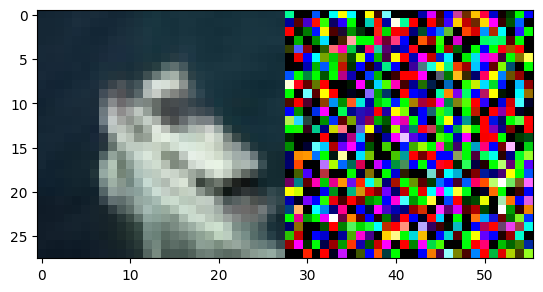

In [ ]:
#@title debug dataset

for batch_idx, (data, target) in enumerate(train_dloader):
    # Get the first batch of images
    if batch_idx == 0:
        # Plot the images
        print(data.shape, target)
        plt.imshow(data[0,:,:,:].permute(1, 2, 0))
        # fig, axs = plt.subplots(1, len(data))
        # for i, image in enumerate(data):
        #     axs[i].imshow(image.permute(1, 2, 0))
        #     axs[i].axis('off')
        # plt.show()
        break

In [ ]:
iterations = 200


# rectified_flow_1 = RectifiedFlow(model=UNet(3, 64, args.num_color).to('cuda'), num_steps=1000)
# rectified_flow_1 = RectifiedFlow(model=MLP(args.image_size, args.num_color).to('cuda'), num_steps=1000)
# rectified_flow_1 = RectifiedFlow(model=ConvTransposeNet(3, 64, args.num_color).to('cuda'), num_steps=1000)
rectified_flow_1 = RectifiedFlow(model=ScoreNet(args.num_color).to('cuda'), num_steps=1000)


ckpt = torch.load('model_150.pt', map_location='cuda')
rectified_flow_1.model.load_state_dict(ckpt)


<All keys matched successfully>

In [ ]:

# optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
optimizer = torch.optim.Adam(rectified_flow_1.model.parameters(), lr=args.learning_rate)

# epochs_lr_decay     = [iterations//3, iterations*2//3]
# lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
#                                               milestones=epochs_lr_decay,
#                                               gamma=0.1)

rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, None, train_dloader, iterations, args)
# rectified_flow_1, loss_curve = train_rectified_flow(rectified_flow_1, optimizer, train_dloader, iterations, args)

plt.plot(np.linspace(0, iterations, iterations+1), loss_curve[:(iterations+1)])
plt.title('Training Loss Curve')
wandb.finish()

In [ ]:
z0_test = torch.normal(0, 1, size=(1024,args.num_color,args.image_size,args.image_size)).to('cuda')
traj = rectified_flow_1.sample_ode(z0=z0_test, N=1000)
images = traj[-1]


In [ ]:

grid = make_grid(images[:64, :, :, :], nrow=8, normalize=True, scale_each=True)
grid = grid.permute(1, 2, 0).cpu().numpy()
plt.imshow(grid)
plt.show()

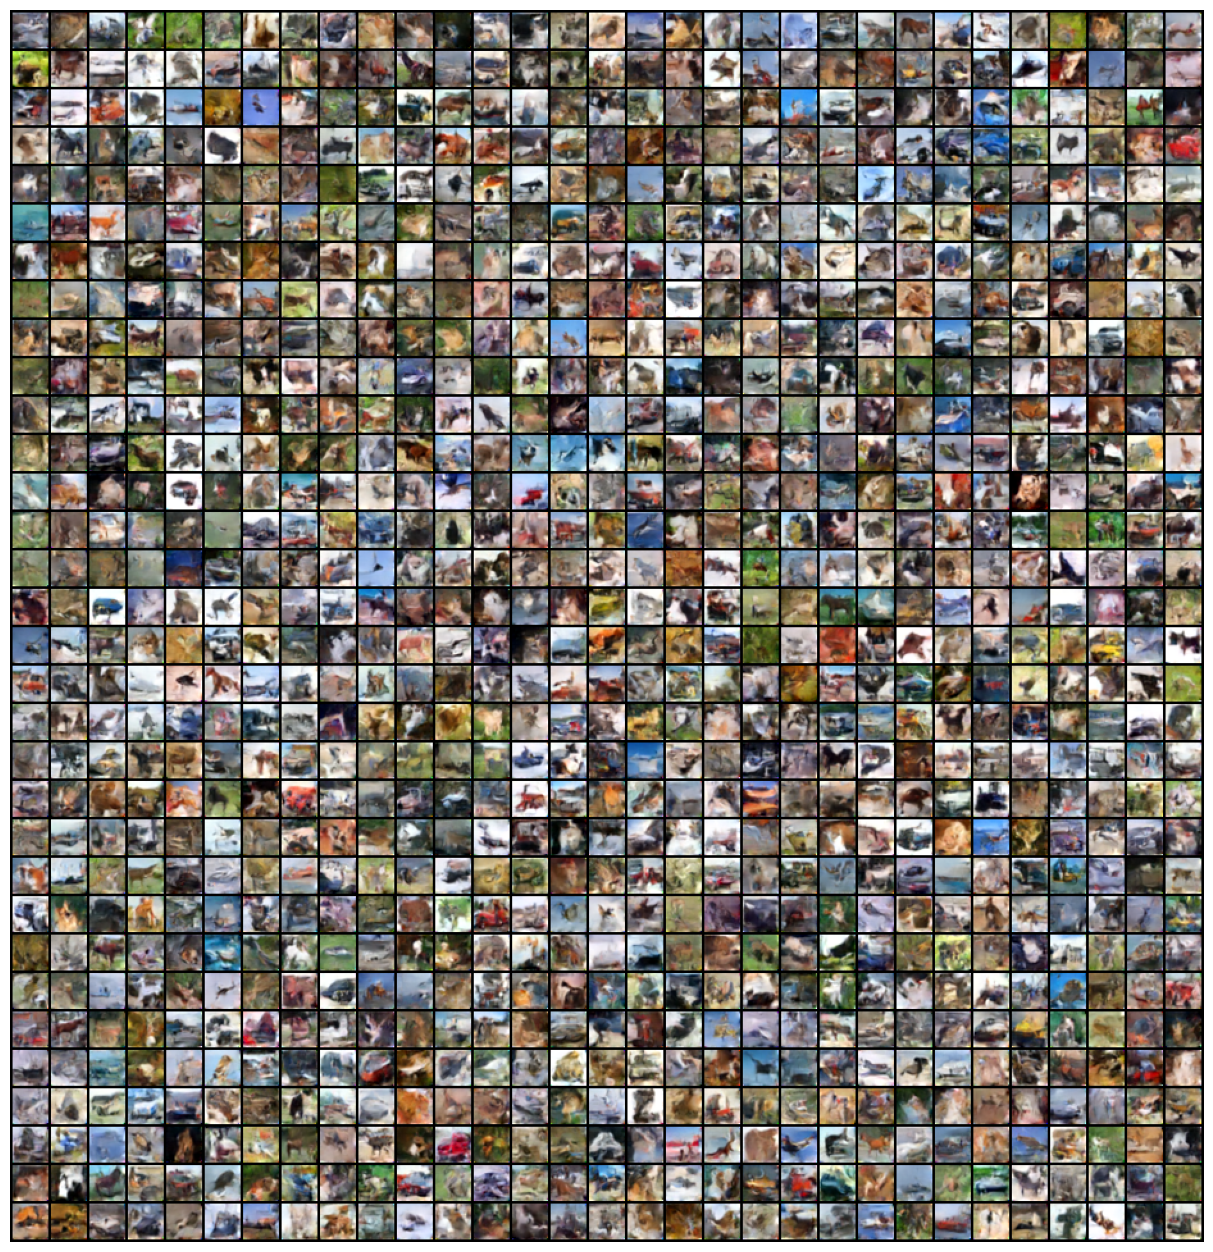

In [ ]:
nsample=992
z0_test = torch.normal(0, 1, size=(nsample,args.num_color,args.image_size,args.image_size)).to('cuda')
traj = rectified_flow_1.sample_ode(z0=z0_test, N=1000)
imgs = traj[-1]
import matplotlib.pyplot as plt
# sample_grid = make_grid(imgs[:,:,:25,:25], nrow=int(np.sqrt(nsample)))
sample_grid = make_grid(imgs[:,:,:,:], nrow=int(np.sqrt(nsample)))

plt.figure(figsize=(16,16))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [ ]:
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        # print(batch)
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [ ]:
class IgnoreLabelDataset(torch.utils.data.Dataset):
    def __init__(self, orig):
          self.orig = orig

    def __getitem__(self, index):
          return self.orig[index][0]

    def __len__(self):
          return len(self.orig)

import torchvision.datasets as dset
import torchvision.transforms as transforms
td = torch.utils.data.TensorDataset(images)

print("Calculating Inception Score...")
print(inception_score(IgnoreLabelDataset(td), cuda=True, batch_size=16, resize=True, splits=10))